# **IMI BIG DATA & AI CASE COMPETITION**

## *By: Hafsa, Cindy, Tahir & Albert*

Recall that most of our exploratory work, and finding out the best cleaning methods was conducted in the Exploratory Data Analysis Notebook. <br>
Here, we just use the best methods to move on to the next phase, and build some more features with our data. <br>
Then, we save the feature generated data and move onto the feature selection phase. 

# Initial Set-Up & Import Data <a class="anchor" id="1"></a>

In [14]:
# Import relevent Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import math

# Model Metrics & Data Pre-processing 
from scipy import stats
from sklearn import metrics
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

#Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

#import lightgbm and xgboost 
import lightgbm as lgb 
import xgboost as xgb 

# Imbalance dataset methods
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN

# Miscellaneous
from collections import Counter

# Additional Libraries -- Automatic Explanatory Data Analysis
from pandas_profiling import ProfileReport
from IPython.core.display import display, HTML

# Remove warnings (so it doesn't take up space)
import warnings
warnings.filterwarnings('ignore')

# Set seed for repition 
np.random.seed(2022)

In [15]:
# Some settings for making the tables, plots and the report look nicer
sns.set_theme()
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 999)
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>.container { length:100% !important; }</style>")) 

In [16]:
# Read in the data
# Canadian Companies Data
df1 = pd.read_excel("/Users/tahir/Desktop/Fraudit/Datasets/cmeg_df_case_competition_scrambled_train.xlsx")

# General Companies Data
df2 = pd.read_excel("/Users/tahir/Desktop/Fraudit/Datasets/general_industries_df_case_competition_scrambled_train.xlsx")

# Data Dictionary from Canadian Companies Dataset (Although both data dictionaries are the same) 
data_dictionary = pd.read_excel("/Users/tahir/Desktop/Fraudit/Datasets/cmeg_df_case_competition_scrambled_train.xlsx", sheet_name=1)


## Data Cleaning Methods <a class="anchor" id="2.2"></a>
### Data Prep -- Column Types, Date Manipulations, Fixing infinity values <a class="anchor" id="2.2.1"></a>


In [17]:
# Fix the object type column to datetime
df1["Date"] = pd.to_datetime(df1.Period)
df2["Date"] = pd.to_datetime(df1.Period)

# Drop the object column
df1 = df1.drop(['Period'], axis=1)
df2 = df2.drop(['Period'], axis=1)
df1.info() # Now we have removed the Object column, and got the date as a datetime column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28224 entries, 0 to 28223
Columns: 125 entries, ROW to Date
dtypes: datetime64[ns](1), float64(118), int64(6)
memory usage: 26.9 MB


In [18]:
# Extract year and month for df1
df1['Year'] = df1['Date'].dt.year
df1['Month'] = df1['Date'].dt.month

# Do the same for df2
df2['Year'] = df2['Date'].dt.year
df2['Month'] = df2['Date'].dt.month

In [19]:
# Fix the infinity Issues (Some columns have values at infinity -- Fix this )
def impute_inf(data,col):
    #Impute -inf of the column of data as the minimum of the rest
    #Impute inf of the column of data as the maximum of the rest
    data.loc[data[col] == -np.inf, col] = data.loc[(data[col] > -np.inf) & (data[col] < np.inf),col].min()
    data.loc[data[col] == np.inf, col] = data.loc[(data[col] < np.inf) & (data[col] < np.inf),col].max()

    return data

# Replace all -/+ inf values with min and max values of the dataset 
for col in df1.columns:
    if col in ["Date","Period"]: pass
    else: df1 = impute_inf(df1,col)

# Do the same for General Companies 
for col in df2.columns:
    if col in ["Date","Period"]: pass
    else: df2 = impute_inf(df2,col)

## Generate a missing data label

In [20]:
missing_label = []
for i in range(len(df1.index)):
    missing_values_per_row = df1.iloc[i].isnull().sum()
    if missing_values_per_row <= 15:
        missing_label.append(1)
    elif (missing_values_per_row >= 16 and missing_values_per_row <= 45):
        missing_label.append(2)
    else: 
        missing_label.append(3)
        
df1["missing_data_flag"] = missing_label

In [21]:
# Do the same for df2
missing_label = []
for i in range(len(df2.index)):
    missing_values_per_row = df2.iloc[i].isnull().sum()
    if missing_values_per_row <= 15:
        missing_label.append(1)
    elif (missing_values_per_row >= 16 and missing_values_per_row <= 45):
        missing_label.append(2)
    else: 
        missing_label.append(3)

df2["missing_data_flag"] = missing_label

## Check & fix outliers

In [22]:
data1 = df1.copy()
non_financial_features = ['ROW','Corp_Residence_Country_Code', 'BR Code', 'CUSTOMER_ID', 'Final_IG', 'B_PLUS_FLAG', 'Year', 'Month', 'Date']
financial_features = data1.drop(non_financial_features, axis=1)
fin_features_lst = list(financial_features.columns)

def outlier_replace(data, col_name, q1=0.25, q3=0.75):
    quartile1 = data[col_name].quantile(q1)
    quartile3 = data[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    data.loc[(data[col_name] < low_limit), col_name] = low_limit
    data.loc[(data[col_name] > up_limit), col_name] = up_limit
    
# Fix outliers in Financial Features for DF1
for col in df1.columns:
    if col in fin_features_lst:
        outlier_replace(df1,col)
    else:
        pass

# Do the same for DF2
for col in df2.columns:
    if col in fin_features_lst:
        outlier_replace(df2,col)
    else:
        pass

## Impute Missing Data

In [23]:
# # Essentially we are filling every column with it's grouped ID's average value per column. 
def impute_average_and_constant(data,group = 'CUSTOMER_ID',constant = 0):
  """This will impute the missing values by grouping the dataset based on a shared value in a column. 
  If no groups can be made (i.e. only one dataset in a group, then the missing data will be imputed with a constant.
  
  data - the data table to be imputed on. Type = pandas dataframe
  group - the column to group by. Default is CUSTOMER_ID
  constant - the constant to impute any data that cannot be grouped. Default is 0
  
  """
  for col in data.columns:
    data[col] = data.groupby('CUSTOMER_ID')[col].apply(lambda x:x.fillna(x.mean()))

  data = data.fillna(constant)
  return data

# This is now clean, imputed data.
df1 = impute_average_and_constant(df1)
df2 = impute_average_and_constant(df2)

In [24]:
df1.isnull().sum()

ROW                            0
Corp_Residence_Country_Code    0
BR Code                        0
CUSTOMER_ID                    0
Final_IG                       0
B_PLUS_FLAG                    0
EBITDA_Y0                      0
EBITDA_Y1                      0
EBITDA_Y2                      0
EBITDA_Y3                      0
TOTALASSET_Y0                  0
TOTALASSET_Y1                  0
TOTALASSET_Y2                  0
TOTALASSET_Y3                  0
TOTALDEBT_Y0                   0
TOTALDEBT_Y1                   0
TOTALDEBT_Y2                   0
TOTALDEBT_Y3                   0
TOTALREVENUE_Y0                0
TOTALREVENUE_Y1                0
TOTALREVENUE_Y2                0
TOTALREVENUE_Y3                0
CURRENTASSET_Y0                0
CURRENTASSET_Y1                0
CURRENTASSET_Y2                0
CURRENTASSET_Y3                0
FIXEDASSET_Y0                  0
FIXEDASSET_Y1                  0
FIXEDASSET_Y2                  0
FIXEDASSET_Y3                  0
CURRENTLIA

# Feature Engineering <a class="anchor" id="4"></a>

## Creating Additional Financial Features<a class="anchor" id="4.1"></a>

We create few additional features which to better be able to predict the investment flag for a company. <br>
Total leverage = debt / ebitda <br>
Ebitda margin = ebitda / revenue  <br>
Operating margin = operating profit / revenue <br> 
Interest Coverage Ratio = Ebitda / interest  <br>
Average growth by Revenue = (Revenue Growth in year 2 + Revenue Growth in year 1) / 2

In [25]:
# Use Data Dictionary 
data_dictionary

,Column,Description
0,Corp_Residence_Country_Code,Country Code
1,BR Code,Industry Code
2,Period,Year quarter
3,Period_Numeric,Quarter
4,CUSTOMER_ID (Tokenized),Technical ID
5,RATING_SAVE_DATE,Rating date
6,STATEMENT_DATE,Financial statement date
7,Final_IG,Final risk rating (after credit officer assess...
8,B_PLUS_FLAG,B+ rating flag
9,EBITDA_Y0,"EBITDA (Earnings Before Interest, Taxes, Depre..."


## Creating Three Year Averages for Financial Columns

In [26]:
def three_year_average(dataframe,col_y0,col_y1,col_y2,col):
  dataframe.drop(dataframe[dataframe[col_y0].isnull()].index, inplace = True)
  #Remove those records if the first year financial info is not available

  two_years_average = dataframe[col_y1].notnull() & dataframe[col_y2].isnull()
  dataframe.loc[two_years_average, col] = dataframe.loc[two_years_average,col_y0] * 4/7 + dataframe.loc[two_years_average,col_y1] * 3/7

  three_years_average = dataframe[col_y1].notnull() & dataframe[col_y2].notnull()
  dataframe.loc[three_years_average, col] = dataframe.loc[three_years_average,col_y0] * 4/9 + dataframe.loc[three_years_average,col_y1] * 3/9 + dataframe.loc[three_years_average,col_y2] * 2/9

  return dataframe

def dataframe_plus_three_year_average(dataframe):
  columns = list(dataframe.columns)
  year_list = ['_Y0','_Y1','_Y2','_Y3']
  year_dictionary = {}
  year_dictionary['Features'] = []
  for year in year_list:
    year_dictionary[year] = []
    for col in columns:
      if year in col: 
        year_dictionary[year].append(col) #Separates out the features based on year (purpose = organization)
        if col[:-3] not in year_dictionary['Features']:
          year_dictionary['Features'].append(col[:-3])

  #Build the new dataset using three year averages
  cols_to_avg = []
  for feature in year_dictionary['Features']:
    cols_to_avg.append([feature + '_Y0', feature + '_Y1', feature + '_Y2', feature + '_3YearAverage'])

  for col1, col2, col3, col in cols_to_avg:
    dataframe = three_year_average(dataframe, col1, col2, col3, col)

  return dataframe


In [27]:
#Append three year averages to dataset 1
df1 = dataframe_plus_three_year_average(df1)
df1.head()

,ROW,Corp_Residence_Country_Code,BR Code,CUSTOMER_ID,Final_IG,B_PLUS_FLAG,EBITDA_Y0,EBITDA_Y1,EBITDA_Y2,EBITDA_Y3,TOTALASSET_Y0,TOTALASSET_Y1,TOTALASSET_Y2,TOTALASSET_Y3,TOTALDEBT_Y0,TOTALDEBT_Y1,TOTALDEBT_Y2,TOTALDEBT_Y3,TOTALREVENUE_Y0,TOTALREVENUE_Y1,TOTALREVENUE_Y2,TOTALREVENUE_Y3,CURRENTASSET_Y0,CURRENTASSET_Y1,CURRENTASSET_Y2,CURRENTASSET_Y3,FIXEDASSET_Y0,FIXEDASSET_Y1,FIXEDASSET_Y2,FIXEDASSET_Y3,CURRENTLIABILITY_Y0,CURRENTLIABILITY_Y1,CURRENTLIABILITY_Y2,CURRENTLIABILITY_Y3,NONCURRLIA_Y0,NONCURRLIA_Y1,NONCURRLIA_Y2,NONCURRLIA_Y3,TOTALEQUITY_Y0,TOTALEQUITY_Y1,TOTALEQUITY_Y2,TOTALEQUITY_Y3,TOTALNETWORTH_Y0,TOTALNETWORTH_Y1,TOTALNETWORTH_Y2,TOTALNETWORTH_Y3,CAPITALIZATION_Y0,CAPITALIZATION_Y1,CAPITALIZATION_Y2,CAPITALIZATION_Y3,TOTINTEXP_Y0,TOTINTEXP_Y1,TOTINTEXP_Y2,TOTINTEXP_Y3,LEASERENTEXP_Y0,LEASERENTEXP_Y1,LEASERENTEXP_Y2,LEASERENTEXP_Y3,EBITDAR_Y0,EBITDAR_Y1,EBITDAR_Y2,EBITDAR_Y3,receivabledays_Y0,receivabledays_Y1,receivabledays_Y2,receivabledays_Y3,INVENTORYDAYS_Y0,INVENTORYDAYS_Y1,INVENTORYDAYS_Y2,INVENTORYDAYS_Y3,payableDAYS_Y0,payableDAYS_Y1,payableDAYS_Y2,payableDAYS_Y3,Capex2Dep_Y0,Capex2Dep_Y1,Capex2Dep_Y2,tangibleNetWorth_Y0,tangibleNetWorth_Y1,tangibleNetWorth_Y2,tangibleNetWorth_Y3,FIXEDCHARGECOV_Y0,FIXEDCHARGECOV_Y1,FIXEDCHARGECOV_Y2,FIXEDCHARGECOV_Y3,DEBTSERVCOV_Y0,DEBTSERVCOV_Y1,DEBTSERVCOV_Y2,DEBTSERVCOV_Y3,NETPROFIT_Y0,NETPROFIT_Y1,NETPROFIT_Y2,NETPROFIT_Y3,NETSALES_Y0,NETSALES_Y1,NETSALES_Y2,NETSALES_Y3,ASSETTURNOVER_Y0,ASSETTURNOVER_Y1,ASSETTURNOVER_Y2,ASSETTURNOVER_Y3,OPERPROFIT_Y0,OPERPROFIT_Y1,OPERPROFIT_Y2,OPERPROFIT_Y3,ARTurnover_Y0,ARTurnover_Y1,ARTurnover_Y2,ARTurnover_Y3,Inventory_Y0,Inventory_Y1,Inventory_Y2,Inventory_Y3,RETAINED_EARNINGS_Y0,RETAINED_EARNINGS_Y1,RETAINED_EARNINGS_Y2,RETAINED_EARNINGS_Y3,FCF_Y0,FCF_Y1,FCF_Y2,CCE_Y0,CCE_Y1,CCE_Y2,CCE_Y3,Date,Year,Month,missing_data_flag,EBITDA_3YearAverage,TOTALASSET_3YearAverage,TOTALDEBT_3YearAverage,TOTALREVENUE_3YearAverage,CURRENTASSET_3YearAverage,FIXEDASSET_3YearAverage,CURRENTLIABILITY_3YearAverage,NONCURRLIA_3YearAverage,TOTALEQUITY_3YearAverage,TOTALNETWORTH_3YearAverage,CAPITALIZATION_3YearAverage,TOTINTEXP_3YearAverage,LEASERENTEXP_3YearAverage,EBITDAR_3YearAverage,receivabledays_3YearAverage,INVENTORYDAYS_3YearAverage,payableDAYS_3YearAverage,Capex2Dep_3YearAverage,tangibleNetWorth_3YearAverage,FIXEDCHARGECOV_3YearAverage,DEBTSERVCOV_3YearAverage,NETPROFIT_3YearAverage,NETSALES_3YearAverage,ASSETTURNOVER_3YearAverage,OPERPROFIT_3YearAverage,ARTurnover_3YearAverage,Inventory_3YearAverage,RETAINED_EARNINGS_3YearAverage,FCF_3YearAverage,CCE_3YearAverage
0,5662,1,5,1576,5,1,575863.911214,602838.635998,583646.469630,614602.866245,619611.510181,621095.725446,611355.907673,582433.004400,623105.791017,596800.177680,600460.033208,598408.339905,611355.411490,589592.109008,605336.777910,574789.603998,620745.952718,621004.600446,614991.732391,604478.517167,609095.636450,600147.701765,589971.619360,580405.105567,578103.988392,577109.531117,574090.626783,583030.371565,600890.935743,604975.472270,600103.052065,601804.995337,596259.219747,573227.115787,572126.125957,601814.939331,578045.252633,571339.795861,596653.190112,590035.602606,571736.508285,628719.211745,584338.549368,616858.074405,611986.404942,604922.163814,577051.576457,613092.388218,603141.577521,576650.299516,620686.247107,610847.649882,585871.251511,616877.792537,568949.503421,618110.180319,604601.169985,580153.927795,590842.797526,590664.224219,590472.808115,616986.562624,572661.424837,574363.146314,582917.058057,583420.366083,607467.206600,583658.695782,603769.043190,601041.664461,590112.115029,590316.935078,602489.197881,607756.994574,602468.604889,579949.325730,585896.605197,615126.516293,604036.179493,573565.511062,607130.118230,571946.940867,592574.187811,623675.986993,618944.803911,580343.279228,590502.807033,609912.733618,599498.344764,595156.410271,587134.042491,570091.364648,580823.373014,608524.711934,622059.106399,575870.723892,573508.493635,570519.450943,608807.689045,5

In [28]:
#Append three year averages to dataset 2
df2 = dataframe_plus_three_year_average(df2)
df2.head()

,ROW,Corp_Residence_Country_Code,BR Code,CUSTOMER_ID,Final_IG,B_PLUS_FLAG,EBITDA_Y0,EBITDA_Y1,EBITDA_Y2,EBITDA_Y3,TOTALASSET_Y0,TOTALASSET_Y1,TOTALASSET_Y2,TOTALASSET_Y3,TOTALDEBT_Y0,TOTALDEBT_Y1,TOTALDEBT_Y2,TOTALDEBT_Y3,TOTALREVENUE_Y0,TOTALREVENUE_Y1,TOTALREVENUE_Y2,TOTALREVENUE_Y3,CURRENTASSET_Y0,CURRENTASSET_Y1,CURRENTASSET_Y2,CURRENTASSET_Y3,FIXEDASSET_Y0,FIXEDASSET_Y1,FIXEDASSET_Y2,FIXEDASSET_Y3,CURRENTLIABILITY_Y0,CURRENTLIABILITY_Y1,CURRENTLIABILITY_Y2,CURRENTLIABILITY_Y3,NONCURRLIA_Y0,NONCURRLIA_Y1,NONCURRLIA_Y2,NONCURRLIA_Y3,TOTALEQUITY_Y0,TOTALEQUITY_Y1,TOTALEQUITY_Y2,TOTALEQUITY_Y3,TOTALNETWORTH_Y0,TOTALNETWORTH_Y1,TOTALNETWORTH_Y2,TOTALNETWORTH_Y3,CAPITALIZATION_Y0,CAPITALIZATION_Y1,CAPITALIZATION_Y2,CAPITALIZATION_Y3,TOTINTEXP_Y0,TOTINTEXP_Y1,TOTINTEXP_Y2,TOTINTEXP_Y3,LEASERENTEXP_Y0,LEASERENTEXP_Y1,LEASERENTEXP_Y2,LEASERENTEXP_Y3,EBITDAR_Y0,EBITDAR_Y1,EBITDAR_Y2,EBITDAR_Y3,receivabledays_Y0,receivabledays_Y1,receivabledays_Y2,receivabledays_Y3,INVENTORYDAYS_Y0,INVENTORYDAYS_Y1,INVENTORYDAYS_Y2,INVENTORYDAYS_Y3,payableDAYS_Y0,payableDAYS_Y1,payableDAYS_Y2,payableDAYS_Y3,Capex2Dep_Y0,Capex2Dep_Y1,Capex2Dep_Y2,tangibleNetWorth_Y0,tangibleNetWorth_Y1,tangibleNetWorth_Y2,tangibleNetWorth_Y3,FIXEDCHARGECOV_Y0,FIXEDCHARGECOV_Y1,FIXEDCHARGECOV_Y2,FIXEDCHARGECOV_Y3,DEBTSERVCOV_Y0,DEBTSERVCOV_Y1,DEBTSERVCOV_Y2,DEBTSERVCOV_Y3,NETPROFIT_Y0,NETPROFIT_Y1,NETPROFIT_Y2,NETPROFIT_Y3,NETSALES_Y0,NETSALES_Y1,NETSALES_Y2,NETSALES_Y3,ASSETTURNOVER_Y0,ASSETTURNOVER_Y1,ASSETTURNOVER_Y2,ASSETTURNOVER_Y3,OPERPROFIT_Y0,OPERPROFIT_Y1,OPERPROFIT_Y2,OPERPROFIT_Y3,ARTurnover_Y0,ARTurnover_Y1,ARTurnover_Y2,ARTurnover_Y3,INVENTORY_Y0,INVENTORY_Y1,INVENTORY_Y2,INVENTORY_Y3,RETAINED_EARNINGS_Y0,RETAINED_EARNINGS_Y1,RETAINED_EARNINGS_Y2,RETAINED_EARNINGS_Y3,FCF_Y0,FCF_Y1,FCF_Y2,CCE_Y0,CCE_Y1,CCE_Y2,CCE_Y3,Date,Year,Month,missing_data_flag,EBITDA_3YearAverage,TOTALASSET_3YearAverage,TOTALDEBT_3YearAverage,TOTALREVENUE_3YearAverage,CURRENTASSET_3YearAverage,FIXEDASSET_3YearAverage,CURRENTLIABILITY_3YearAverage,NONCURRLIA_3YearAverage,TOTALEQUITY_3YearAverage,TOTALNETWORTH_3YearAverage,CAPITALIZATION_3YearAverage,TOTINTEXP_3YearAverage,LEASERENTEXP_3YearAverage,EBITDAR_3YearAverage,receivabledays_3YearAverage,INVENTORYDAYS_3YearAverage,payableDAYS_3YearAverage,Capex2Dep_3YearAverage,tangibleNetWorth_3YearAverage,FIXEDCHARGECOV_3YearAverage,DEBTSERVCOV_3YearAverage,NETPROFIT_3YearAverage,NETSALES_3YearAverage,ASSETTURNOVER_3YearAverage,OPERPROFIT_3YearAverage,ARTurnover_3YearAverage,INVENTORY_3YearAverage,RETAINED_EARNINGS_3YearAverage,FCF_3YearAverage,CCE_3YearAverage
0,28464,2,4,8228,8,1,365604.767017,341575.264490,368053.254720,370696.187829,3.706175e+05,3.497885e+05,3.485696e+05,3.757753e+05,375510.954405,372600.077528,360644.686054,373539.595801,3.560748e+05,3.633396e+05,3.585169e+05,3.715991e+05,3.434351e+05,344977.126649,367162.335140,349945.750055,3.784293e+05,3.720962e+05,3.688327e+05,3.472348e+05,355541.904130,367439.639625,340433.991591,367150.907129,353405.890207,355716.993127,353085.838690,340960.105507,3.533652e+05,3.479149e+05,3.692967e+05,3.636268e+05,3.700049e+05,3.514704e+05,3.668692e+05,3.436602e+05,3.697346e+05,3.551172e+05,3.435738e+05,3.563240e+05,370169.540410,344003.480397,369171.604555,367363.465248,370634.594885,374281.413522,363411.986740,362056.093767,375275.290440,357961.987189,361050.670507,358189.894815,350879.117221,347265.348459,364929.687159,363903.150704,0.000000,0.000000,344807.527334,362378.000450,0.000000,0.000000,343346.372212,356055.826284,362221.588737,340686.574830,362774.829776,342637.201639,349900.900026,367354.207877,346292.283689,351706.612676,393601.766253,320927.055356,320546.133100,359576.687007,394996.818521,320576.856105,320774.648458,356874.643821,361456.227063,342201.418226,348199.125611,3.720583e+05,3.516364e+05,3.525602e+05,3.419070e+05,356742.394668,357520.549624,365255.341936,371843.335476,354543.920069,343724.025034,362427.966074,349247.377743,362545.867031,345369.766302,367117.355311,359257.

In [29]:
# Fix the denominator columns so we don't divide anything by 0. (Changing it to 0.0001 instead)
denominator_cols = ["EBITDA_Y0", "EBITDA_Y1", "EBITDA_Y2", "EBITDA_Y3",
                    "TOTALREVENUE_Y0", "TOTALREVENUE_Y1", "TOTALREVENUE_Y2", "TOTALREVENUE_Y3",
                    "TOTINTEXP_Y0", "TOTINTEXP_Y1", "TOTINTEXP_Y2", "TOTINTEXP_Y3",
                    "CURRENTLIABILITY_Y0", "CURRENTLIABILITY_Y1", "CURRENTLIABILITY_Y2", "CURRENTLIABILITY_Y3",
                    "TOTALASSET_Y0", "TOTALASSET_Y1", "TOTALASSET_Y2", "TOTALASSET_Y3",
                    "NETSALES_Y0", "NETSALES_Y1", "NETSALES_Y2", "NETSALES_Y3",
                    "Average_Total_Assets"
                    ]
for col in df1.columns:
  if col in denominator_cols:
    df1[col]=df1[col].replace(0.000000, 0.0001)
    
for col in df2.columns:
    if col in denominator_cols:
        df2[col]=df2[col].replace(0.000000, 0.0001)

## Generate Ratios which are useful in determining a companies financial well-being

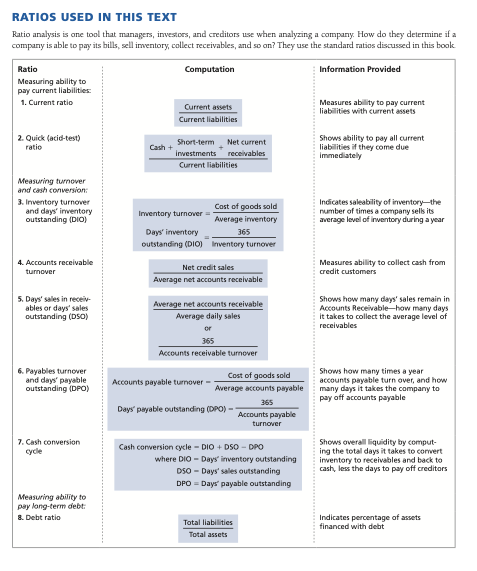

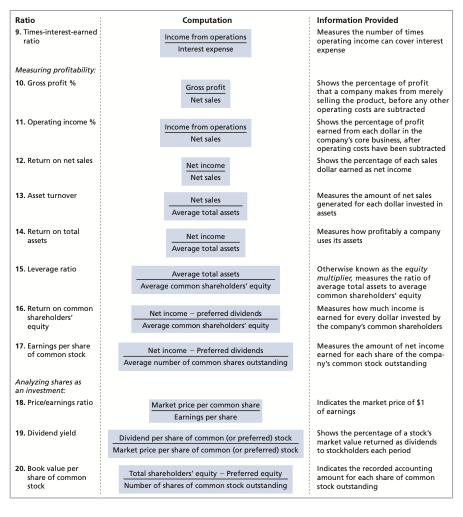

In [30]:
def Total_Leverage(dataset):
    dataset["Total_Leverage_Y0"] = dataset["TOTALDEBT_Y0"] / dataset["EBITDA_Y0"]
    dataset["Total_Leverage_Y1"] = dataset["TOTALDEBT_Y1"] / dataset["EBITDA_Y1"]
    dataset["Total_Leverage_Y2"] = dataset["TOTALDEBT_Y2"] / dataset["EBITDA_Y2"]
    dataset["Total_Leverage_Y3"] = dataset["TOTALDEBT_Y3"] / dataset["EBITDA_Y3"]
    return dataset

def Ebitda_Margin(dataset):
    dataset["Ebitda_Margin_Y0"] = dataset["EBITDA_Y0"] / dataset["TOTALREVENUE_Y0"] 
    dataset["Ebitda_Margin_Y1"] = dataset["EBITDA_Y1"] / dataset["TOTALREVENUE_Y1"] 
    dataset["Ebitda_Margin_Y2"] = dataset["EBITDA_Y2"] / dataset["TOTALREVENUE_Y2"] 
    dataset["Ebitda_Margin_Y3"] = dataset["EBITDA_Y3"] / dataset["TOTALREVENUE_Y3"] 
    return dataset

def Operating_Margin(dataset):
    dataset["Operating_Margin_Y0"] = dataset["EBITDA_Y0"] / dataset["TOTALREVENUE_Y0"] 
    dataset["Operating_Margin_Y1"] = dataset["EBITDA_Y1"] / dataset["TOTALREVENUE_Y1"] 
    dataset["Operating_Margin_Y2"] = dataset["EBITDA_Y2"] / dataset["TOTALREVENUE_Y2"] 
    dataset["Operating_Margin_Y3"] = dataset["EBITDA_Y3"] / dataset["TOTALREVENUE_Y3"] 
    return dataset
    
def Interest_Coverage_Ratio(dataset):
    dataset["Interest_CR_Y0"] = dataset["EBITDA_Y0"] / dataset["TOTINTEXP_Y0"] 
    dataset["Interest_CR_Y1"] = dataset["EBITDA_Y1"] / dataset["TOTINTEXP_Y1"] 
    dataset["Interest_CR_Y2"] = dataset["EBITDA_Y2"] / dataset["TOTINTEXP_Y2"] 
    dataset["Interest_CR_Y3"] = dataset["EBITDA_Y3"] / dataset["TOTINTEXP_Y3"] 
    return dataset

def Average_Growth_By_Revenue(dataset):
    dataset["Growth_Y3_to_Y2"] = (dataset["TOTALREVENUE_Y2"] - dataset["TOTALREVENUE_Y3"]) / (dataset["TOTALREVENUE_Y3"])
    dataset["Growth_Y2_to_Y1"] = (dataset["TOTALREVENUE_Y1"] - dataset["TOTALREVENUE_Y2"]) / (dataset["TOTALREVENUE_Y2"])
    dataset["Average_Growth"] = (dataset["Growth_Y3_to_Y2"] + dataset["Growth_Y2_to_Y1"]) / 2
    return dataset
    
# 1
def Current_Ratio(dataset):
    dataset["Current_Ratio_Y0"] = dataset["CURRENTASSET_Y0"] / dataset["CURRENTLIABILITY_Y0"]
    dataset["Current_Ratio_Y1"] = dataset["CURRENTASSET_Y1"] / dataset["CURRENTLIABILITY_Y1"]
    dataset["Current_Ratio_Y2"] = dataset["CURRENTASSET_Y2"] / dataset["CURRENTLIABILITY_Y2"]
    dataset["Current_Ratio_Y3"] = dataset["CURRENTASSET_Y3"] / dataset["CURRENTLIABILITY_Y3"]
    return dataset

# 2
def Quick_Ratio(dataset):
    dataset["Quick_Ratio_Y0"] = (dataset["CCE_Y0"] + dataset["ARTurnover_Y0"]) / dataset["CURRENTLIABILITY_Y0"]
    dataset["Quick_Ratio_Y1"] = (dataset["CCE_Y1"] + dataset["ARTurnover_Y1"]) / dataset["CURRENTLIABILITY_Y1"]
    dataset["Quick_Ratio_Y2"] = (dataset["CCE_Y2"] + dataset["ARTurnover_Y2"]) / dataset["CURRENTLIABILITY_Y2"]
    dataset["Quick_Ratio_Y3"] = (dataset["CCE_Y3"] + dataset["ARTurnover_Y3"]) / dataset["CURRENTLIABILITY_Y3"]
    return dataset

# 8 
def Debt_Ratio(dataset):
    dataset["Debt_Ratio_Y0"] = dataset["TOTALDEBT_Y0"] / dataset["TOTALASSET_Y0"]
    dataset["Debt_Ratio_Y1"] = dataset["TOTALDEBT_Y1"] / dataset["TOTALASSET_Y1"]
    dataset["Debt_Ratio_Y2"] = dataset["TOTALDEBT_Y2"] / dataset["TOTALASSET_Y2"]
    dataset["Debt_Ratio_Y3"] = dataset["TOTALDEBT_Y3"] / dataset["TOTALASSET_Y3"]
    return dataset

# 13
def Asset_Turnover(dataset):
  dataset["Average_Total_Assets"] = (dataset["CURRENTASSET_Y0"] + dataset["CURRENTASSET_Y1"] + dataset["CURRENTASSET_Y2"] + dataset["CURRENTASSET_Y3"]) / 4
  dataset["Asset_Turnover_Y0"] = dataset["NETSALES_Y0"] / dataset["Average_Total_Assets"]
  dataset["Asset_Turnover_Y1"] = dataset["NETSALES_Y1"] / dataset["Average_Total_Assets"]
  dataset["Asset_Turnover_Y2"] = dataset["NETSALES_Y2"] / dataset["Average_Total_Assets"]
  dataset["Asset_Turnover_Y3"] = dataset["NETSALES_Y3"] / dataset["Average_Total_Assets"]
  return dataset

# 12
def Return_Net_Sales(dataset):
    dataset["Return_Net_Sales_Y0"] = dataset["EBITDA_Y0"] / dataset["NETSALES_Y0"]
    dataset["Return_Net_Sales_Y1"] = dataset["EBITDA_Y1"] / dataset["NETSALES_Y1"]
    dataset["Return_Net_Sales_Y2"] = dataset["EBITDA_Y2"] / dataset["NETSALES_Y2"]
    dataset["Return_Net_Sales_Y3"] = dataset["EBITDA_Y3"] / dataset["NETSALES_Y3"]
    return dataset


def Create_Features(my_df):
    Total_Leverage(my_df)
    Ebitda_Margin(my_df)
    Operating_Margin(my_df)
    Interest_Coverage_Ratio(my_df)
    Average_Growth_By_Revenue(my_df)
    Current_Ratio(my_df)
    Quick_Ratio(my_df)
    Debt_Ratio(my_df)
    Return_Net_Sales(my_df)
    Asset_Turnover(my_df)
    return my_df

Create_Features(df1)
Create_Features(df2)
print(" ")

In [31]:
df1.head()

,ROW,Corp_Residence_Country_Code,BR Code,CUSTOMER_ID,Final_IG,B_PLUS_FLAG,EBITDA_Y0,EBITDA_Y1,EBITDA_Y2,EBITDA_Y3,TOTALASSET_Y0,TOTALASSET_Y1,TOTALASSET_Y2,TOTALASSET_Y3,TOTALDEBT_Y0,TOTALDEBT_Y1,TOTALDEBT_Y2,TOTALDEBT_Y3,TOTALREVENUE_Y0,TOTALREVENUE_Y1,TOTALREVENUE_Y2,TOTALREVENUE_Y3,CURRENTASSET_Y0,CURRENTASSET_Y1,CURRENTASSET_Y2,CURRENTASSET_Y3,FIXEDASSET_Y0,FIXEDASSET_Y1,FIXEDASSET_Y2,FIXEDASSET_Y3,CURRENTLIABILITY_Y0,CURRENTLIABILITY_Y1,CURRENTLIABILITY_Y2,CURRENTLIABILITY_Y3,NONCURRLIA_Y0,NONCURRLIA_Y1,NONCURRLIA_Y2,NONCURRLIA_Y3,TOTALEQUITY_Y0,TOTALEQUITY_Y1,TOTALEQUITY_Y2,TOTALEQUITY_Y3,TOTALNETWORTH_Y0,TOTALNETWORTH_Y1,TOTALNETWORTH_Y2,TOTALNETWORTH_Y3,CAPITALIZATION_Y0,CAPITALIZATION_Y1,CAPITALIZATION_Y2,CAPITALIZATION_Y3,TOTINTEXP_Y0,TOTINTEXP_Y1,TOTINTEXP_Y2,TOTINTEXP_Y3,LEASERENTEXP_Y0,LEASERENTEXP_Y1,LEASERENTEXP_Y2,LEASERENTEXP_Y3,EBITDAR_Y0,EBITDAR_Y1,EBITDAR_Y2,EBITDAR_Y3,receivabledays_Y0,receivabledays_Y1,receivabledays_Y2,receivabledays_Y3,INVENTORYDAYS_Y0,INVENTORYDAYS_Y1,INVENTORYDAYS_Y2,INVENTORYDAYS_Y3,payableDAYS_Y0,payableDAYS_Y1,payableDAYS_Y2,payableDAYS_Y3,Capex2Dep_Y0,Capex2Dep_Y1,Capex2Dep_Y2,tangibleNetWorth_Y0,tangibleNetWorth_Y1,tangibleNetWorth_Y2,tangibleNetWorth_Y3,FIXEDCHARGECOV_Y0,FIXEDCHARGECOV_Y1,FIXEDCHARGECOV_Y2,FIXEDCHARGECOV_Y3,DEBTSERVCOV_Y0,DEBTSERVCOV_Y1,DEBTSERVCOV_Y2,DEBTSERVCOV_Y3,NETPROFIT_Y0,NETPROFIT_Y1,NETPROFIT_Y2,NETPROFIT_Y3,NETSALES_Y0,NETSALES_Y1,NETSALES_Y2,NETSALES_Y3,ASSETTURNOVER_Y0,ASSETTURNOVER_Y1,ASSETTURNOVER_Y2,ASSETTURNOVER_Y3,OPERPROFIT_Y0,OPERPROFIT_Y1,OPERPROFIT_Y2,OPERPROFIT_Y3,ARTurnover_Y0,ARTurnover_Y1,ARTurnover_Y2,ARTurnover_Y3,Inventory_Y0,Inventory_Y1,Inventory_Y2,Inventory_Y3,RETAINED_EARNINGS_Y0,RETAINED_EARNINGS_Y1,RETAINED_EARNINGS_Y2,RETAINED_EARNINGS_Y3,FCF_Y0,FCF_Y1,FCF_Y2,CCE_Y0,CCE_Y1,CCE_Y2,CCE_Y3,Date,Year,Month,missing_data_flag,EBITDA_3YearAverage,TOTALASSET_3YearAverage,TOTALDEBT_3YearAverage,TOTALREVENUE_3YearAverage,CURRENTASSET_3YearAverage,FIXEDASSET_3YearAverage,CURRENTLIABILITY_3YearAverage,NONCURRLIA_3YearAverage,TOTALEQUITY_3YearAverage,TOTALNETWORTH_3YearAverage,CAPITALIZATION_3YearAverage,TOTINTEXP_3YearAverage,LEASERENTEXP_3YearAverage,EBITDAR_3YearAverage,receivabledays_3YearAverage,INVENTORYDAYS_3YearAverage,payableDAYS_3YearAverage,Capex2Dep_3YearAverage,tangibleNetWorth_3YearAverage,FIXEDCHARGECOV_3YearAverage,DEBTSERVCOV_3YearAverage,NETPROFIT_3YearAverage,NETSALES_3YearAverage,ASSETTURNOVER_3YearAverage,OPERPROFIT_3YearAverage,ARTurnover_3YearAverage,Inventory_3YearAverage,RETAINED_EARNINGS_3YearAverage,FCF_3YearAverage,CCE_3YearAverage,Total_Leverage_Y0,Total_Leverage_Y1,Total_Leverage_Y2,Total_Leverage_Y3,Ebitda_Margin_Y0,Ebitda_Margin_Y1,Ebitda_Margin_Y2,Ebitda_Margin_Y3,Operating_Margin_Y0,Operating_Margin_Y1,Operating_Margin_Y2,Operating_Margin_Y3,Interest_CR_Y0,Interest_CR_Y1,Interest_CR_Y2,Interest_CR_Y3,Growth_Y3_to_Y2,Growth_Y2_to_Y1,Average_Growth,Current_Ratio_Y0,Current_Ratio_Y1,Current_Ratio_Y2,Current_Ratio_Y3,Quick_Ratio_Y0,Quick_Ratio_Y1,Quick_Ratio_Y2,Quick_Ratio_Y3,Debt_Ratio_Y0,Debt_Ratio_Y1,Debt_Ratio_Y2,Debt_Ratio_Y3,Return_Net_Sales_Y0,Return_Net_Sales_Y1,Return_Net_Sales_Y2,Return_Net_Sales_Y3,Average_Total_Assets,Asset_Turnover_Y0,Asset_Turnover_Y1,Asset_Turnover_Y2,Asset_Turnover_Y3
0,5662,1,5,1576,5,1,575863.911214,602838.635998,583646.469630,614602.866245,619611.510181,621095.725446,611355.907673,582433.004400,623105.791017,596800.177680,600460.033208,598408.339905,611355.411490,589592.109008,605336.777910,574789.603998,620745.952718,621004.600446,614991.732391,604478.517167,609095.636450,600147.701765,589971.619360,580405.105567,578103.988392,577109.531117,574090.626783,583030.371565,600890.935743,604975.472270,600103.052065,601804.995337,596259.219747,573227.115787,572126.125957,601814.939331,578045.252633,571339.795861,596653.190112,590035.602606,571736.508285,628719.211745,584338.549368,616858.074405,611986.404942,604922.163814,577051.576457,613092.388218,603141.577521,576650.299516,620

In [32]:
print("Original Dataset shape was: (28224, 125)")
print("Now, we have:", df1.shape)

Original Dataset shape was: (28224, 125)
Now, we have: (28224, 198)


A total of over 73 new columns were created! 

In [33]:
# Feature Engineering Completed
df1.to_excel("Feature_Engineering_Completed_df1.xlsx")
df2.to_excel("Feature_Engineering_Completed_df2.xlsx")